In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import seaborn as sns

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, f1_score
from wordcloud import WordCloud, STOPWORDS
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor 
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, FunctionTransformer
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [2]:
pd.set_option('display.max_columns', 50)
pd.set_option('display.width', 120)

FILE_PATH = os.environ.get('IMDB_CSV', 'desafio_indicium_imdb.csv')
df = pd.read_csv(FILE_PATH)
print('Shape:', df.shape)
df.head(5)

Shape: (999, 16)


,Unnamed: 0,Series_Title,Released_Year,Certificate,Runtime,Genre,IMDB_Rating,Overview,Meta_score,Director,Star1,Star2,Star3,Star4,No_of_Votes,Gross
0,1,The Godfather,1972,A,175 min,"Crime, Drama",9.2,An organized crime dynasty's aging patriarch t...,100.0,Francis Ford Coppola,Marlon Brando,Al Pacino,James Caan,Diane Keaton,1620367,"134,966,411"
1,2,The Dark Knight,2008,UA,152 min,"Action, Crime, Drama",9.0,When the menace known as the Joker wreaks havo...,84.0,Christopher Nolan,Christian Bale,Heath Ledger,Aaron Eckhart,Michael Caine,2303232,"534,858,444"
2,3,The Godfather: Part II,1974,A,202 min,"Crime, Drama",9.0,The early life and career of Vito Corleone in ...,90.0,Francis Ford Coppola,Al Pacino,Robert De Niro,Robert Duvall,Diane Keaton,1129952,"57,300,000"
3,4,12 Angry Men,1957,U,96 min,"Crime, Drama",9.0,A jury holdout attempts to prevent a miscarria...,96.0,Sidney Lumet,Henry Fonda,Lee J. Cobb,Martin Balsam,John Fiedler,689845,"4,360,000"
4,5,The Lord of the Rings: The Return of the King,2003,U,201 min,"Action, Adventure, Drama",8.9,Gandalf and Aragorn lead the World of Men agai...,94.0,Peter Jackson,Elijah Wood,Viggo Mortensen,Ian McKellen,Orlando Bloom,1642758,"377,845,905"


In [3]:
print("Shape:", df.shape)
print("\nTipos de dados:")
print(df.dtypes)

Shape: (999, 16)

Tipos de dados:
Unnamed: 0         int64
Series_Title      object
Released_Year     object
Certificate       object
Runtime           object
Genre             object
IMDB_Rating      float64
Overview          object
Meta_score       float64
Director          object
Star1             object
Star2             object
Star3             object
Star4             object
No_of_Votes        int64
Gross             object
dtype: object


In [4]:
print("\nResumo numérico:")
print(df.describe(include=[np.number]).T)


Resumo numérico:
             count           mean            std      min      25%       50%       75%        max
Unnamed: 0   999.0     500.000000     288.530761      1.0    250.5     500.0     749.5      999.0
IMDB_Rating  999.0       7.947948       0.272290      7.6      7.7       7.9       8.1        9.2
Meta_score   842.0      77.969121      12.383257     28.0     70.0      79.0      87.0      100.0
No_of_Votes  999.0  271621.422422  320912.621055  25088.0  55471.5  138356.0  373167.5  2303232.0


In [5]:
print("\nResumo categórico:")
print(df.describe(include=['object']).T)


Resumo categórico:
              count unique                                                top freq
Series_Title    999    998                                           Drishyam    2
Released_Year   999    100                                               2014   32
Certificate     898     16                                                  U  234
Runtime         999    140                                            100 min   23
Genre           999    202                                              Drama   84
Overview        999    999  An organized crime dynasty's aging patriarch t...    1
Director        999    548                                   Alfred Hitchcock   14
Star1           999    659                                          Tom Hanks   12
Star2           999    840                                        Emma Watson    7
Star3           999    890                                       Rupert Grint    5
Star4           999    938                                      Mic

In [6]:
print("\nPercentual de nulos:")
print((df.isna().mean() * 100).round(2).sort_values(ascending=False))


Percentual de nulos:
Gross            16.92
Meta_score       15.72
Certificate      10.11
Unnamed: 0        0.00
Runtime           0.00
Genre             0.00
Series_Title      0.00
Released_Year     0.00
Overview          0.00
IMDB_Rating       0.00
Star1             0.00
Director          0.00
Star2             0.00
Star3             0.00
Star4             0.00
No_of_Votes       0.00
dtype: float64


In [7]:
print("\nValores únicos por coluna:")
print(df.nunique())


Valores únicos por coluna:
Unnamed: 0       999
Series_Title     998
Released_Year    100
Certificate       16
Runtime          140
Genre            202
IMDB_Rating       16
Overview         999
Meta_score        63
Director         548
Star1            659
Star2            840
Star3            890
Star4            938
No_of_Votes      998
Gross            822
dtype: int64


In [8]:
num_cols = ["IMDB_Rating", "Meta_score", "No_of_Votes", "Runtime_min", "Released_Year", "Gross_num"]

cat_cols = ['Series_Title', 'Certificate', 'Runtime', 
            'Genre', 'Overview', 'Director', 'Star1', 'Star2', 'Star3', 'Star4', 'Gross']


df["Runtime_min"] = (
    df["Runtime"].astype(str)
    .str.replace(" min", "", regex=False)
    .str.replace(r"\D", "", regex=True)
    .replace("", np.nan)
    .astype(float)
)
df["Gross_num"] = (
    df["Gross"].astype(str)
    .str.replace(",", "", regex=False)
    .replace({"": np.nan, "nan": np.nan})
    .astype(float)
)
df["Main_Genre"] = df["Genre"].astype(str).str.split(",").str[0].str.strip()
df["Released_Year_clean"] = pd.to_numeric(
    df["Released_Year"].astype(str).str.extract(r"(\d{4})")[0],
    errors="coerce"
)
df["Released_Year"] = pd.to_numeric(
    df["Released_Year"].astype(str).str.extract(r"(\d{4})")[0],
    errors="coerce"
)

def robust_minmax(s):
    s = pd.to_numeric(s, errors="coerce")
    lo, hi = s.quantile(0.01), s.quantile(0.99)
    return (s.clip(lo, hi) - lo) / (hi - lo) if hi > lo else pd.Series(0.5, index=s.index)

df["z_imdb"] = robust_minmax(df["IMDB_Rating"])
df["z_meta"] = robust_minmax(df["Meta_score"]).fillna(df["z_imdb"])
df["z_votes"] = robust_minmax(df["No_of_Votes"])

friendly_genres = {"Drama", "Adventure", "Action", "Comedy", "Animation", "Family"}
df["z_genre"] = df["Main_Genre"].apply(lambda g: 1.0 if g in friendly_genres else 0.6)

def comfort_runtime(x):
    if pd.isna(x): return 0.7
    if 95 <= x <= 150: return 1.0
    if x < 95:  return max(0.5, 1 - (95 - x) / 60)
    return max(0.5, 1 - (x - 150) / 80)

df["z_runtime"] = df["Runtime_min"].apply(comfort_runtime)

def recency_bonus(y):
    if pd.isna(y): return 0.8
    return np.clip((y - 1960) / (2020 - 1960), 0, 1) * 0.3 + 0.7

df["z_year"] = df["Released_Year_clean"].apply(recency_bonus)

w_imdb, w_meta, w_votes, w_genre, w_runtime, w_year = 0.35, 0.20, 0.20, 0.10, 0.10, 0.05
df["rec_score"] = (
    w_imdb * df["z_imdb"]
    + w_meta * df["z_meta"]
    + w_votes * df["z_votes"]
    + w_genre * df["z_genre"]
    + w_runtime * df["z_runtime"]
    + w_year * df["z_year"]
)

df['Released_Year'] = pd.to_numeric(df['Released_Year'].astype(str).str.extract(r'(\d{4})')[0], errors='coerce')
df['Runtime_min'] = (
    df['Runtime']
    .astype(str)
    .str.replace(' min', '', regex=False)
    .str.replace(r'\D', '', regex=True)
    .replace('', np.nan)
    .astype(float)
)

df['Main_Genre'] = df['Genre'].astype(str).str.split(',').str[0].str.strip()
df['Votes_log1p'] = np.log1p(df['No_of_Votes'])

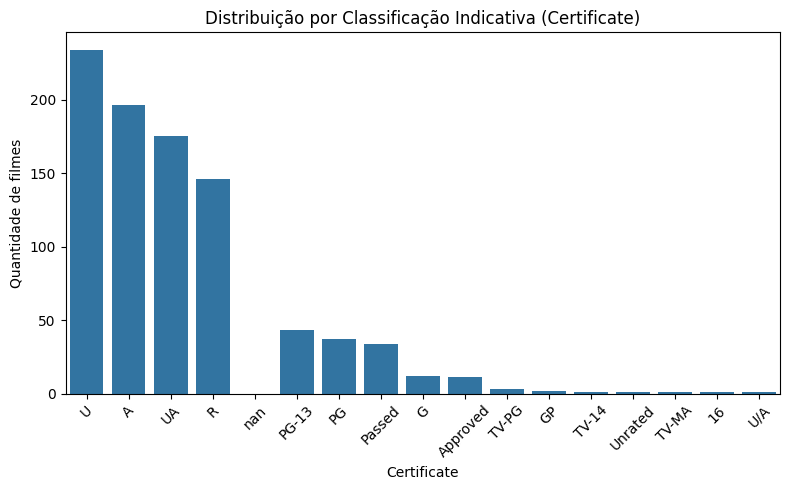

In [9]:
plt.figure(figsize=(8,5))
sns.countplot(
    x="Certificate",
    data=df,
    order=df["Certificate"].value_counts(dropna=False).index
)
plt.title("Distribuição por Classificação Indicativa (Certificate)")
plt.xlabel("Certificate")
plt.ylabel("Quantidade de filmes")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

- As classificações U (Universal), A e UA dominam o dataset, representando juntas a maior parte dos filmes. Isso indica que há predomínio de produções acessíveis ao público em geral e famílias, sugerindo foco em alcance massivo.

- Filmes com classificação R (restrição a menores) também têm volume relevante, mas bem menor do que U, A e UA.

- A categoria nan aparece em quantidade considerável, revelando que nem todos os filmes têm classificação informada.

- As categorias TV-PG, TV-14, TV-MA aparecem em frequência muito baixa. Sugere que o dataset é predominantemente de filmes de cinema, com poucos registros de produções televisivas/streaming.

- Categorias como Approved e GP são raras, possivelmente relacionadas a sistemas de classificação mais antigos ou específicos de determinados países.

/tmp/ipykernel_313047/1389531901.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="Main_Genre", y="IMDB_Rating", data=df_genres, palette="Set2")
/tmp/ipykernel_313047/1389531901.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="Main_Genre", y="Meta_score", data=df_genres, palette="Set3")


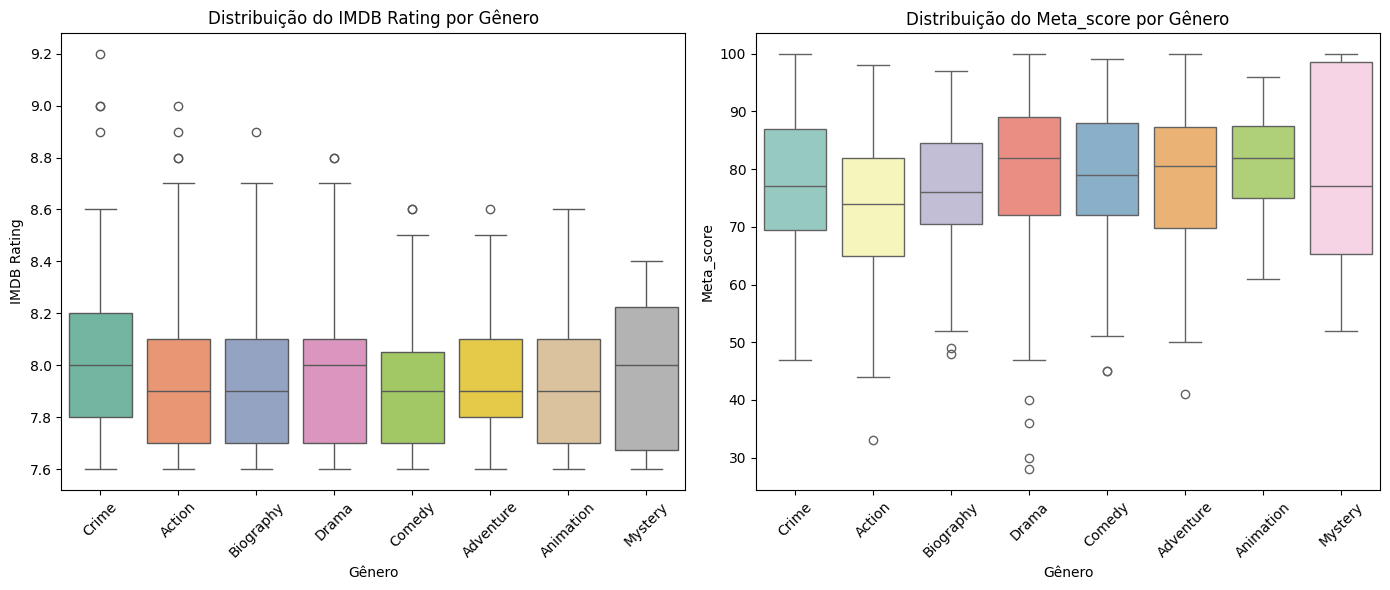

In [10]:
df["Main_Genre"] = df["Genre"].astype(str).str.split(",").str[0].str.strip()
top_genres = df["Main_Genre"].value_counts().head(8).index
df_genres = df[df["Main_Genre"].isin(top_genres)]

plt.figure(figsize=(14,6))
plt.subplot(1,2,1)
sns.boxplot(x="Main_Genre", y="IMDB_Rating", data=df_genres, palette="Set2")
plt.title("Distribuição do IMDB Rating por Gênero")
plt.xlabel("Gênero")
plt.ylabel("IMDB Rating")
plt.xticks(rotation=45)

plt.subplot(1,2,2)
sns.boxplot(x="Main_Genre", y="Meta_score", data=df_genres, palette="Set3")
plt.title("Distribuição do Meta_score por Gênero")
plt.xlabel("Gênero")
plt.ylabel("Meta_score")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

IMDB Rating por Gênero

- Distribuição bem homogênea entre os gêneros (medianas próximas de 7.8–8.0).

- Crime e Mystery tendem a ter avaliações ligeiramente mais altas. Poucos outliers positivos, indicando raros filmes com notas acima de 9.0.

Meta_score por Gênero

- Diferença mais acentuada entre gêneros do que no IMDB Rating.

- Drama, Comedy e Mystery apresentam maior variação, com casos de notas baixas (<40).

- Animation e Crime têm distribuição mais concentrada em notas altas (~80–90). Outliers negativos aparecem em quase todos os gêneros, revelando alguns filmes criticamente mal avaliados.


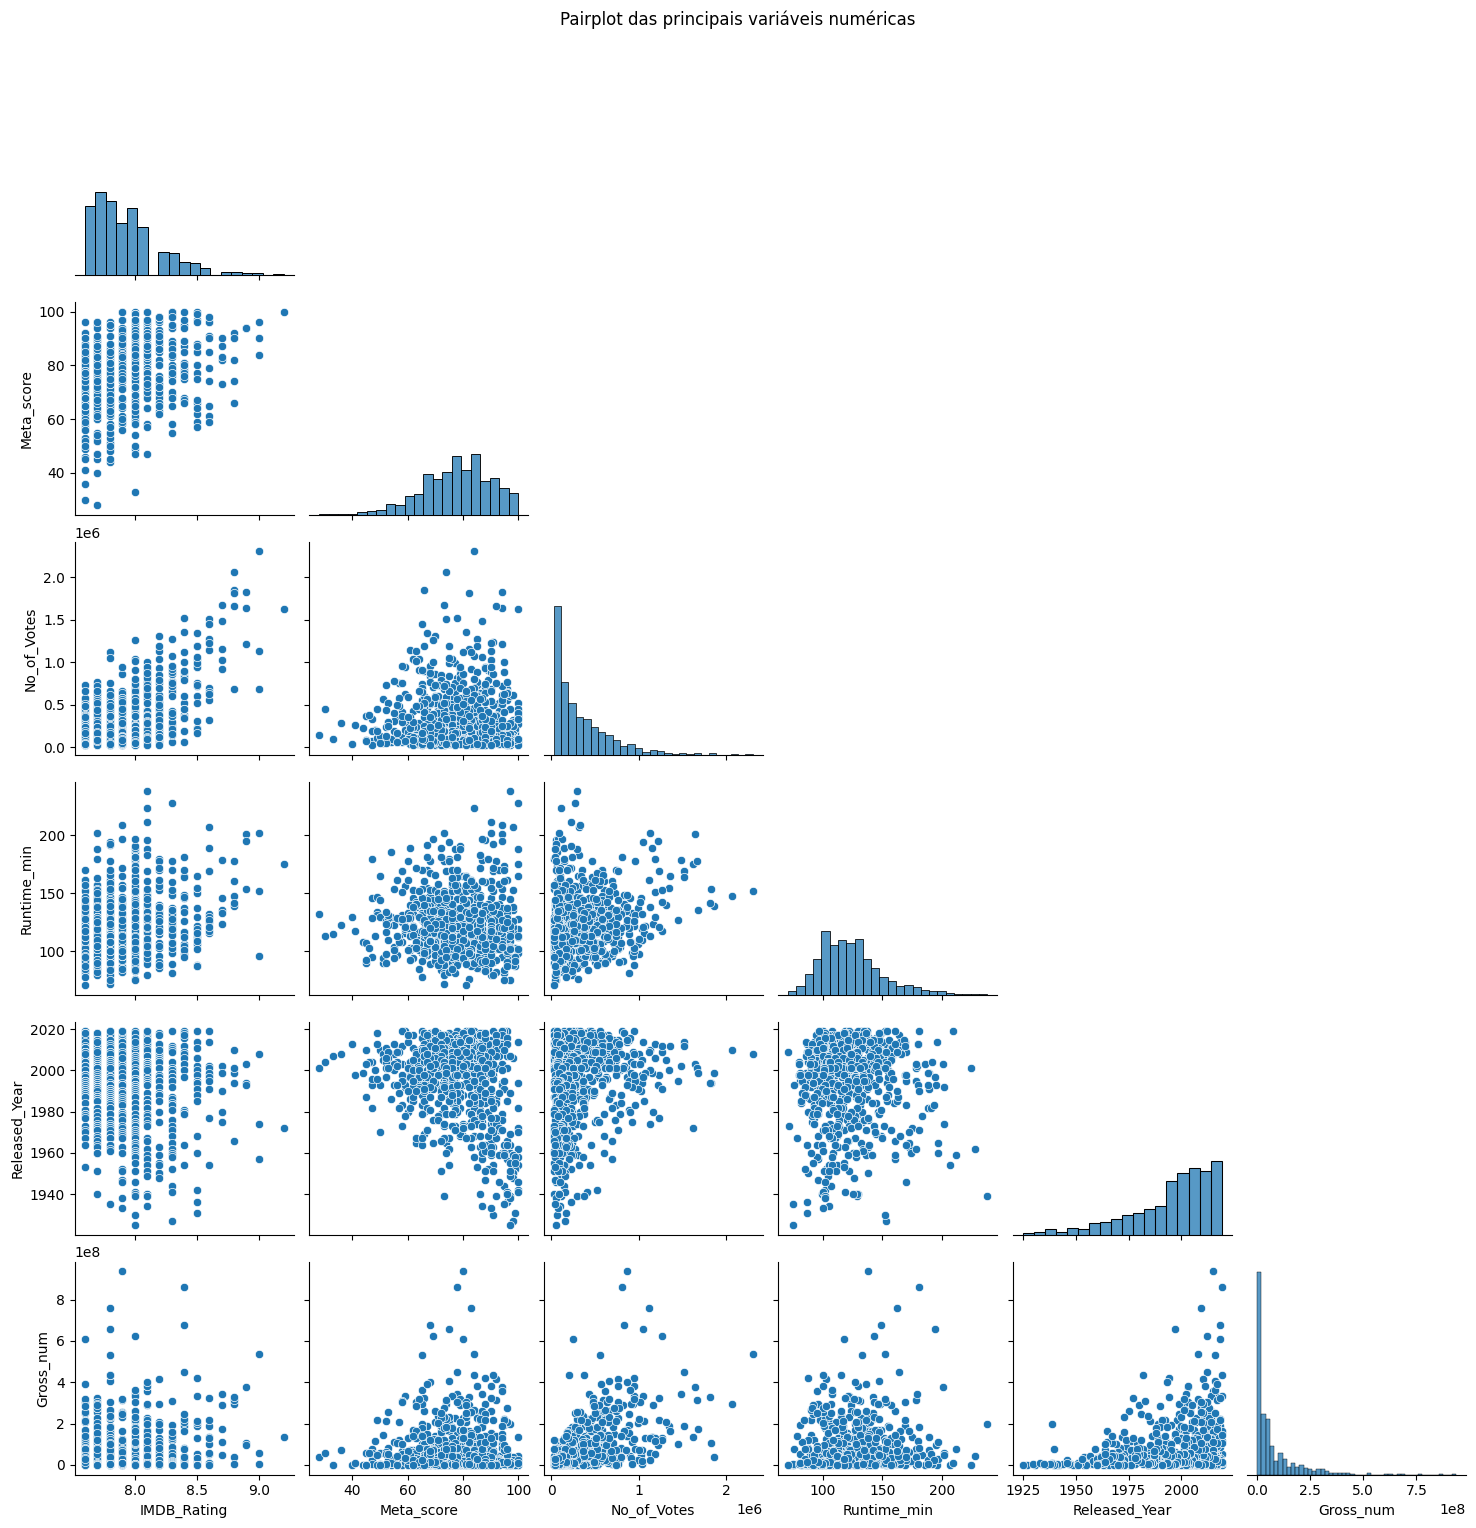

In [11]:
df_pair = df[num_cols].apply(pd.to_numeric, errors="coerce").dropna().astype(float)

sns.pairplot(df_pair, diag_kind="hist", corner=True)
plt.suptitle("Pairplot das principais variáveis numéricas", y=1.02)
plt.show()

IMDb Rating

- Distribuição concentrada entre 7.5 e 8.5, sem grande dispersão. Correlação moderada e positiva com o Meta_score: quanto melhor avaliado pela crítica, maior tende a ser a nota no IMDb.

Meta_score

- Ampla variação (20 a 100). Filmes com muitos votos no IMDb tendem a ter Meta_score mais alto, mas a relação não é linear.

No_of_Votes

- Correlação clara com IMDb Rating: filmes mais votados tendem a ter notas maiores. Relação positiva também com Gross: mais votos costumam indicar maior bilheteria.

Runtime (min)

- Distribuição concentrada entre 90 e 150 minutos. Pouca relação direta com nota ou bilheteria (indica que a duração não garante sucesso).

Released Year

- Concentração de filmes mais recentes (pós-2000). Não há relação clara entre ano e avaliação ou bilheteria (sucesso não depende diretamente da época).

Gross (Bilheteria)

- Distribuição altamente assimétrica: poucos filmes com valores muito altos (outliers). Correlação positiva com número de votos: filmes mais populares geram maior receita.



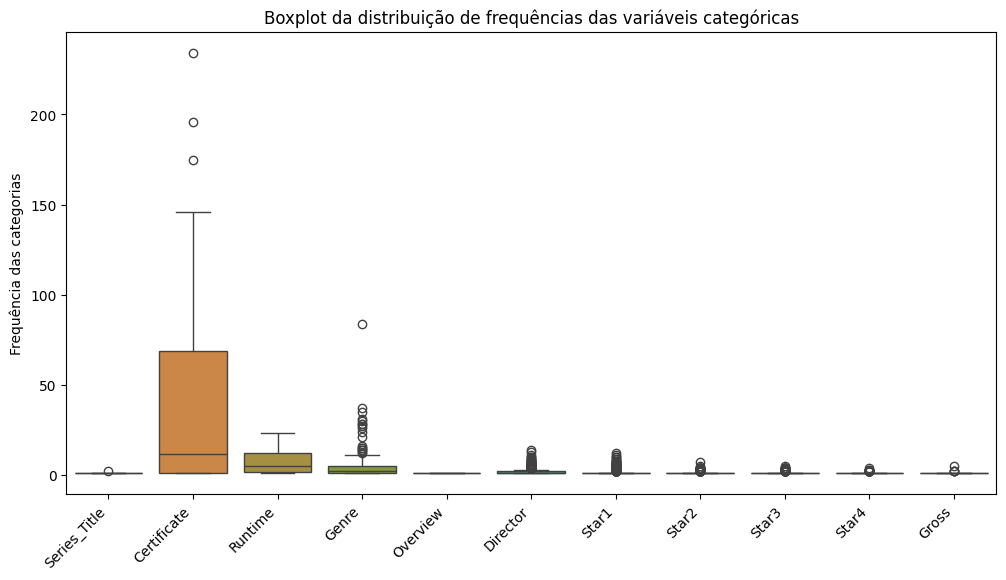

In [12]:
freqs = []
labels = []
for col in cat_cols:
    counts = df[col].value_counts()
    freqs.append(counts.values)
    labels.append(col)

plt.figure(figsize=(12,6))
sns.boxplot(data=freqs)
plt.xticks(range(len(labels)), labels, rotation=45, ha="right")
plt.ylabel("Frequência das categorias")
plt.title("Boxplot da distribuição de frequências das variáveis categóricas")
plt.show()

- O dataset tem categorias muito desbalanceadas: algumas dominam (Certificate, certos gêneros), enquanto outras são únicas ou pouco representadas (atores, diretores).

In [14]:
def hist(series, title, xlabel, bins=30):
    fig = plt.figure(figsize=(8,5))
    plt.hist(series.dropna(), bins=bins)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel('Frequência')
    plt.tight_layout()
    plt.show()

def scatter(x, y, title, xlabel, ylabel, logx=False):
    fig = plt.figure(figsize=(8,6))
    if logx:
        plt.xscale('log')
    plt.scatter(x, y, alpha=0.6)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.tight_layout()
    plt.show()

def lineplot(x, y, title, xlabel, ylabel):
    fig = plt.figure(figsize=(9,5))
    plt.plot(x, y, marker='o')
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.tight_layout()
    plt.show()

def barh(labels, values, title, xlabel, ylabel):
    fig = plt.figure(figsize=(9,6))
    idx = np.arange(len(labels))
    plt.barh(idx, values)
    plt.yticks(idx, labels)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.tight_layout()
    plt.show()

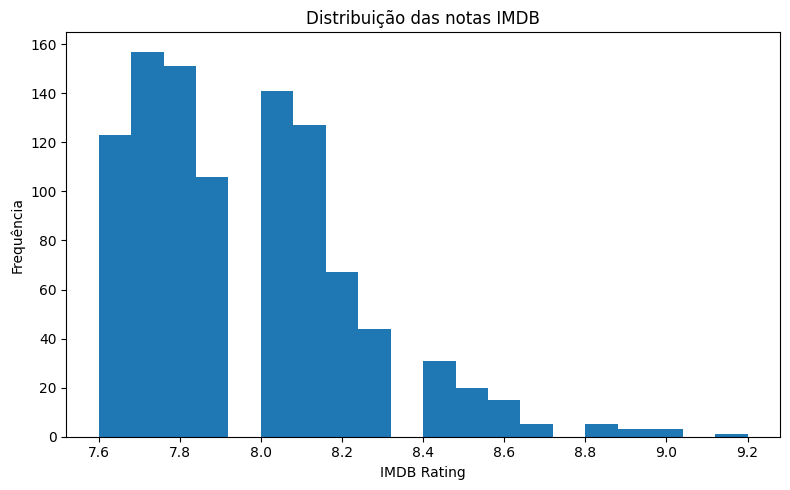

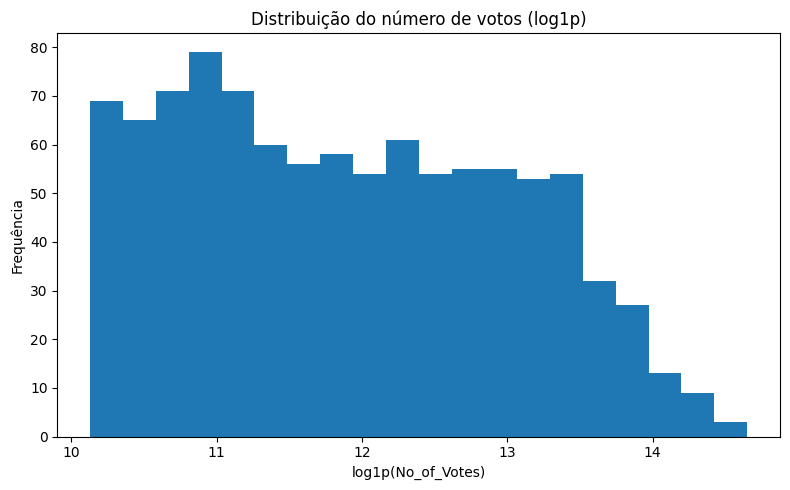

In [15]:
hist(df['IMDB_Rating'], 'Distribuição das notas IMDB', 'IMDB Rating', bins=20)
hist(df['Votes_log1p'], 'Distribuição do número de votos (log1p)', 'log1p(No_of_Votes)', bins=20)

Distribuição das notas IMDb

- Notas estão concentradas entre 7.6 e 8.2, com picos de frequência em torno de 7.7 e 8.0.

- Poucos filmes alcançam notas acima de 8.5, mostrando que avaliações muito altas são raras.

- A cauda à direita indica a presença de alguns clássicos excepcionais (9.0+), mas em minoria.

Distribuição do número de votos (log transformado)

- Após a transformação logarítmica, a distribuição se aproxima de quase simétrica, mas ainda com leve concentração em valores menores.

- A maioria dos filmes tem entre 10¹⁰ e 10¹³ votos (na escala original), ou seja, há grande variação na popularidade.

- Filmes com altíssimo número de votos (blockbusters) são poucos, aparecendo como cauda longa à direita.


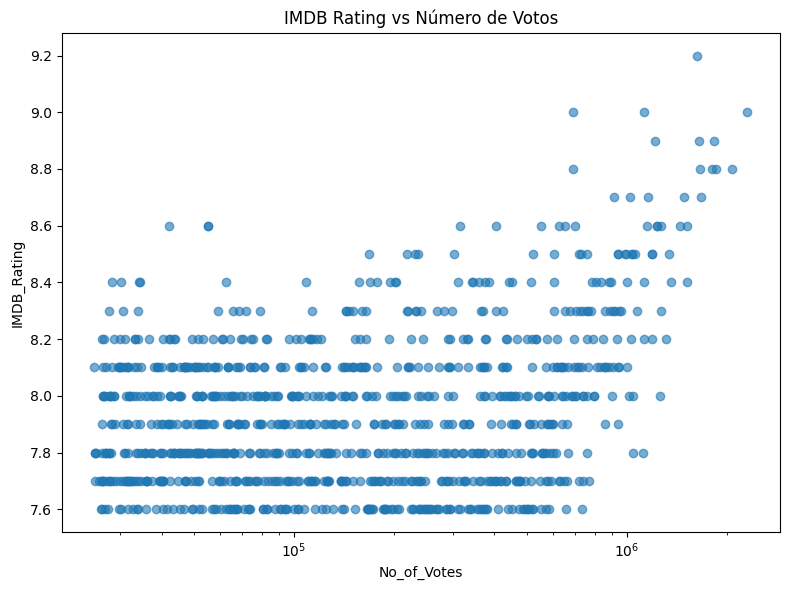

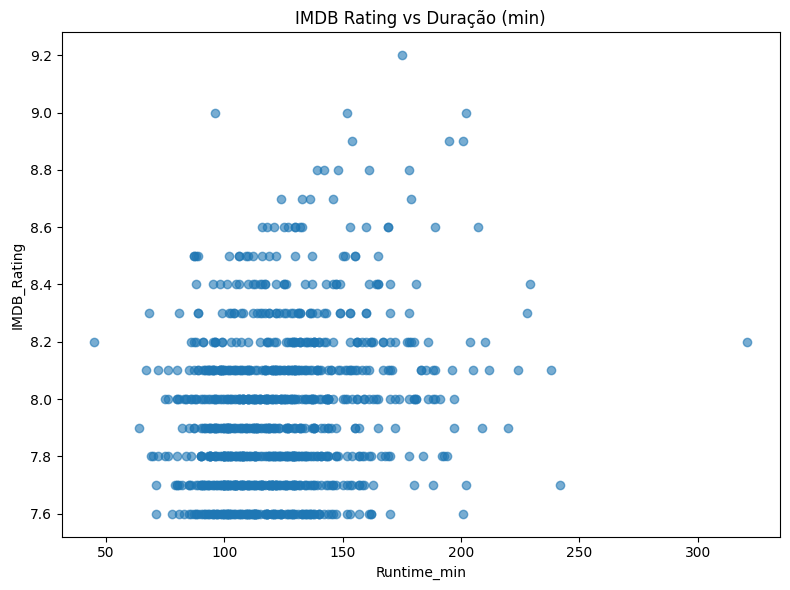

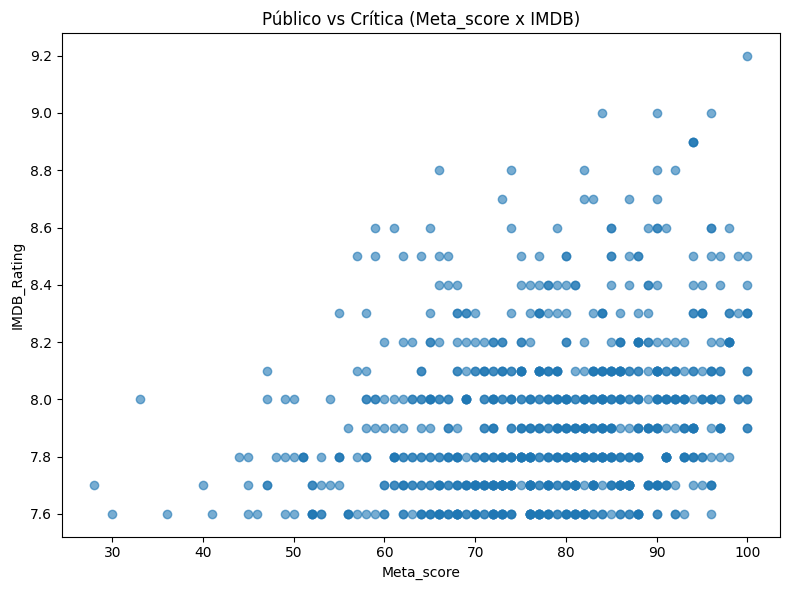

In [16]:
scatter(df['No_of_Votes'], df['IMDB_Rating'], 'IMDB Rating vs Número de Votos', 'No_of_Votes', 'IMDB_Rating', logx=True)
scatter(df['Runtime_min'], df['IMDB_Rating'], 'IMDB Rating vs Duração (min)', 'Runtime_min', 'IMDB_Rating')
scatter(df['Meta_score'], df['IMDB_Rating'], 'Público vs Crítica (Meta_score x IMDB)', 'Meta_score', 'IMDB_Rating')

IMDb Rating vs Número de Votos

- Relação positiva clara: filmes com mais votos tendem a ter notas maiores. Os filmes mais populares (milhões de votos) concentram-se entre 8.0 e 9.2, indicando que audiência em massa geralmente acompanha boas avaliações.

IMDb Rating vs Duração (Runtime)

- A maioria dos filmes dura entre 90 e 150 minutos, independentemente da nota. Não há relação forte entre duração e avaliação: tanto curtas quanto longos podem ter notas altas ou baixas. Filmes muito longos (> 200 min) são minoria e não se destacam em nota.


Meta_score (Crítica) vs IMDb Rating (Público)

- Relação moderadamente positiva: filmes com alta aprovação da crítica (Meta_score > 80) também costumam ser bem avaliados pelo público. Há exceções: alguns filmes com notas boas no IMDb (≈8.0) têm Meta_score baixo (< 50), mostrando divergência entre crítica e público. Poucos filmes combinam nota máxima em ambos os eixos, reforçando que consenso absoluto é raro.




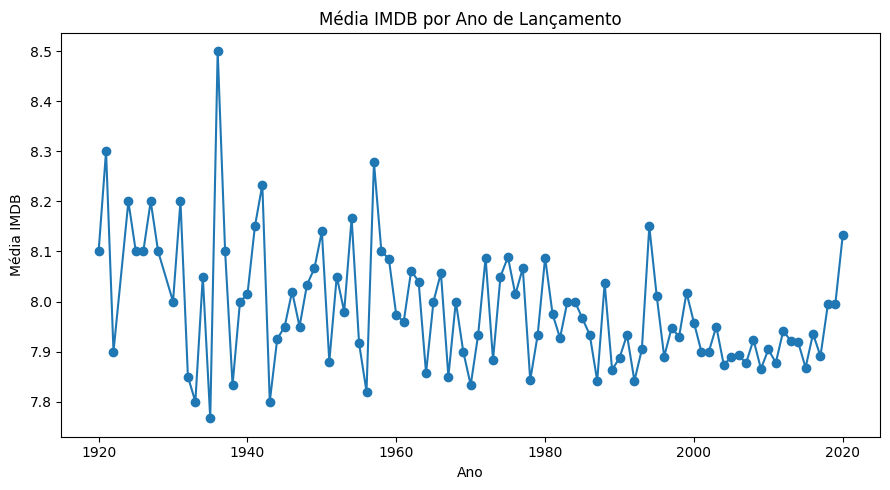

In [17]:
by_year = df.dropna(subset=['Released_Year']).groupby('Released_Year')['IMDB_Rating'].mean().reset_index()
lineplot(by_year['Released_Year'], by_year['IMDB_Rating'], 'Média IMDB por Ano de Lançamento', 'Ano', 'Média IMDB')

- O período clássico do cinema (1930–1960) apresenta médias mais altas e maior oscilação.

- O cinema moderno (1990–2010) mostra estabilidade, mas com notas ligeiramente menores.

- Nos últimos anos, há indício de recuperação, mas ainda sem alcançar os picos do passado.

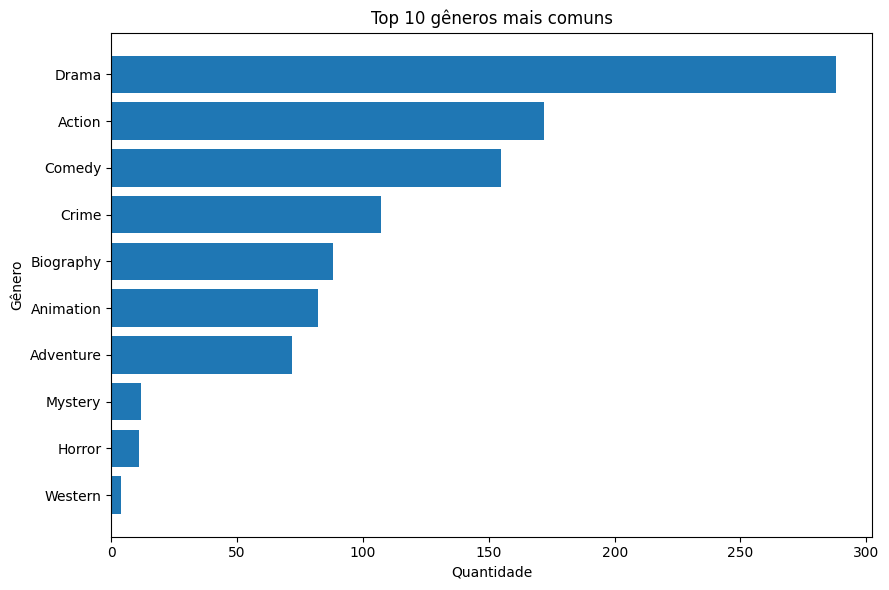

In [18]:
genre_counts = df['Main_Genre'].value_counts().head(10)
barh(genre_counts.index.tolist()[::-1], genre_counts.values.tolist()[::-1], 'Top 10 gêneros mais comuns', 'Quantidade', 'Gênero')

- O dataset é fortemente concentrado em Drama, Ação e Comédia, que juntos representam a maior parte dos filmes.

- Há boa diversidade em gêneros secundários, mas com menor equilíbrio.

- Gêneros de nicho (Horror, Mystery e Western) são pouco representados.

In [19]:
cols_show = [
    "Series_Title", "Released_Year_clean", "Main_Genre", "IMDB_Rating", "Meta_score",
    "No_of_Votes", "Runtime_min", "Gross_num", "rec_score"
]
topN = (
    df.dropna(subset=["IMDB_Rating", "No_of_Votes"])
      .sort_values("rec_score", ascending=False)
      .loc[:, cols_show]
      .head(10)
      .reset_index(drop=True)
)
print(topN.to_string(index=False))

top1 = topN.iloc[0]
print("\nRecomendação universal:", top1["Series_Title"], int(top1["Released_Year_clean"]))


                                     Series_Title  Released_Year_clean Main_Genre  IMDB_Rating  Meta_score  No_of_Votes  Runtime_min   Gross_num  rec_score
                                  The Dark Knight               2008.0     Action          9.0        84.0      2303232        152.0 534858444.0   0.936318
The Lord of the Rings: The Fellowship of the Ring               2001.0     Action          8.8        92.0      1661481        178.0 315544750.0   0.931159
                                     Forrest Gump               1994.0      Drama          8.8        82.0      1809221        142.0 330252182.0   0.928045
                                     Pulp Fiction               1994.0      Crime          8.9        94.0      1826188        154.0 107928762.0   0.926682
    The Lord of the Rings: The Return of the King               2003.0     Action          8.9        94.0      1642758        201.0 377845905.0   0.923932
                                    The Godfather               

/tmp/ipykernel_313047/1533323054.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=corr_gross.values, y=corr_gross.index, palette="viridis")


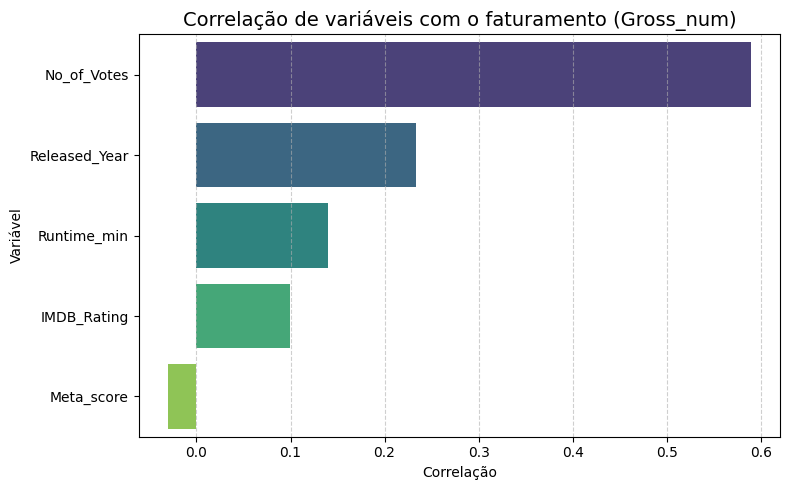

Correlação com Gross_num:
 No_of_Votes      0.590
Released_Year    0.233
Runtime_min      0.140
IMDB_Rating      0.099
Meta_score      -0.030
Name: Gross_num, dtype: float64


In [20]:
corr = df[num_cols].apply(pd.to_numeric, errors="coerce").corr()
corr_gross = corr["Gross_num"].drop("Gross_num").sort_values(ascending=False)

plt.figure(figsize=(8,5))
sns.barplot(x=corr_gross.values, y=corr_gross.index, palette="viridis")
plt.title("Correlação de variáveis com o faturamento (Gross_num)", fontsize=14)
plt.xlabel("Correlação")
plt.ylabel("Variável")
plt.grid(axis="x", linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()

print("Correlação com Gross_num:\n", corr_gross.round(3))

- Popularidade (número de votos) é o melhor preditor de faturamento.

- Fatores técnicos (duração) e qualitativos (nota IMDb, crítica) têm impacto limitado.

- Ano de lançamento mostra que o mercado atual gera mais receitas, independentemente da qualidade avaliada.

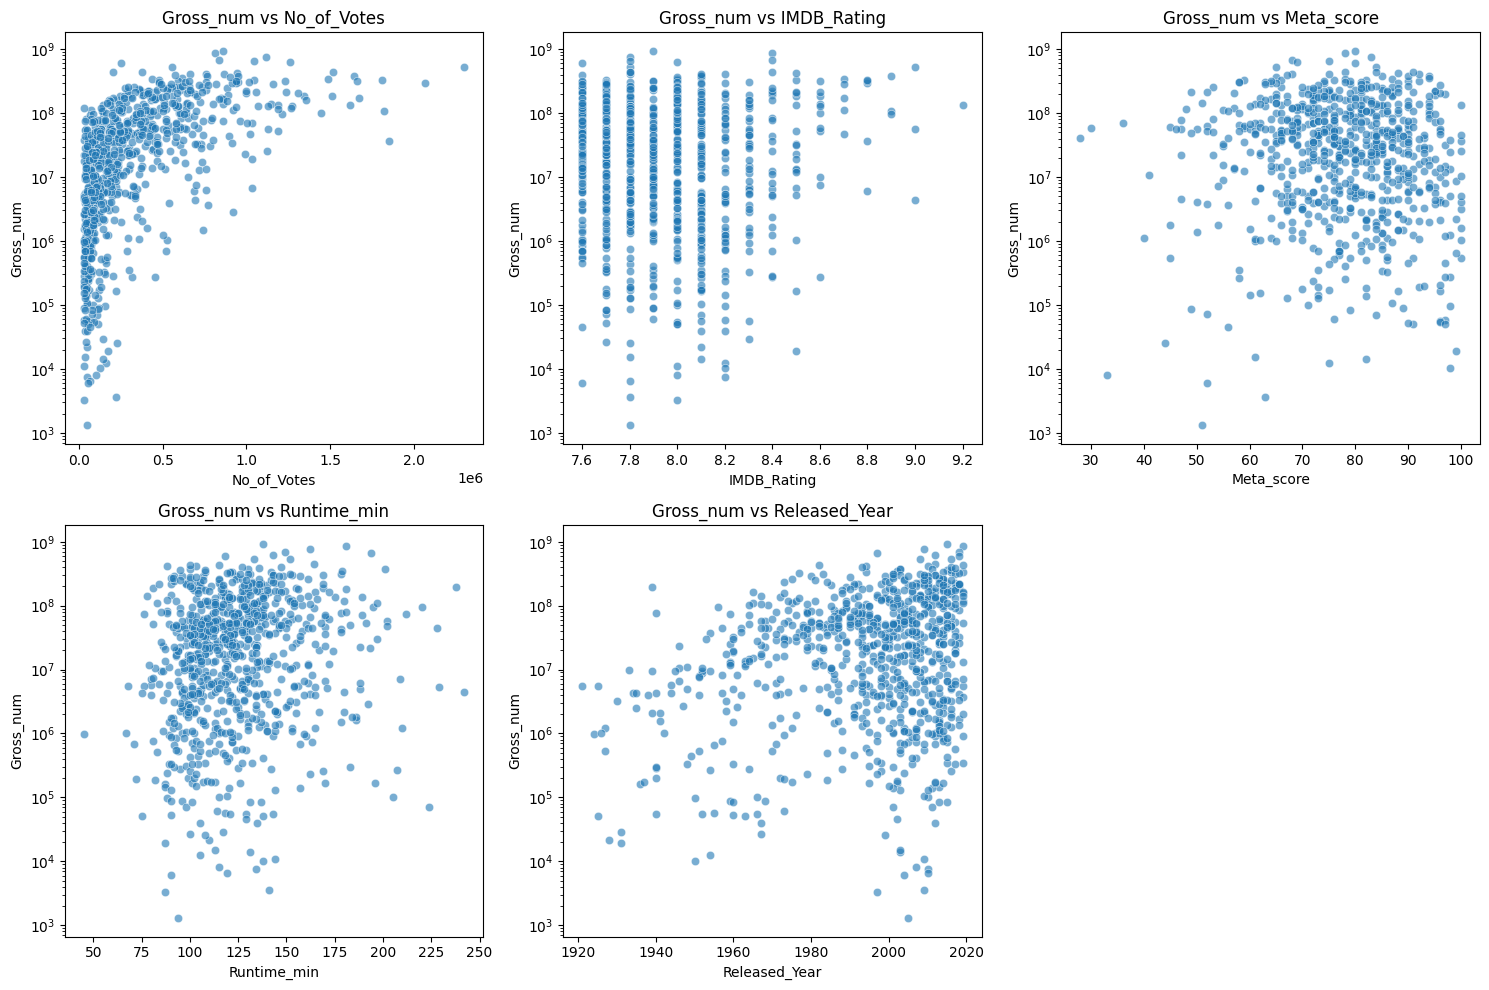

In [21]:
vars_to_plot = ["No_of_Votes", "IMDB_Rating", "Meta_score", "Runtime_min", "Released_Year"]
plt.figure(figsize=(15,10))

for i, col in enumerate(vars_to_plot, 1):
    plt.subplot(2, 3, i)
    sns.scatterplot(x=df[col], y=df["Gross_num"], alpha=0.6)
    plt.title(f"Gross_num vs {col}")
    plt.xlabel(col)
    plt.ylabel("Gross_num")
    plt.yscale("log")

plt.tight_layout()
plt.show()

Gross_num vs No_of_Votes

- Relação positiva e forte: quanto mais votos, maior a bilheteria. Alguns filmes com milhões de votos chegam a arrecadar bilhões.

Gross_num vs IMDb Rating

- Correlação fraca: filmes com notas boas nem sempre arrecadam mais. Há filmes medianos em nota que arrecadaram muito, e filmes bem avaliados que faturaram pouco.

Gross_num vs Meta_score

- Quase nenhuma relação visível. A aprovação da crítica não garante sucesso financeiro.

Gross_num vs Runtime_min

- Não há tendência clara: filmes entre 90 e 150 min concentram a maioria, mas com grande variação no faturamento. Duração não é determinante para bilheteria.

Gross_num vs Released_Year

- Filmes mais recentes (pós-2000) tendem a ter maior bilheteria. Indica o crescimento do mercado cinematográfico global e inflação dos valores arrecadados.


=== Relatório de Classificação (macro) ===
              precision    recall  f1-score   support

      Action      0.542     0.371     0.441        35
   Adventure      0.385     0.357     0.370        14
   Animation      0.333     0.375     0.353        16
   Biography      0.250     0.222     0.235        18
      Comedy      0.409     0.290     0.340        31
       Crime      0.300     0.286     0.293        21
       Drama      0.402     0.569     0.471        58
     Mystery      0.000     0.000     0.000         2
       Other      0.200     0.200     0.200         5

    accuracy                          0.385       200
   macro avg      0.313     0.297     0.300       200
weighted avg      0.387     0.385     0.378       200

Macro-F1: 0.300


/home/josiele/Projeto Pessoal/LH_CD_JOSIELE/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1296: FutureWarning: Using the 'liblinear' solver for multiclass classification is deprecated. An error will be raised in 1.8. Either use another solver which supports the multinomial loss or wrap the estimator in a OneVsRestClassifier to keep applying a one-versus-rest scheme.
  warnings.warn(


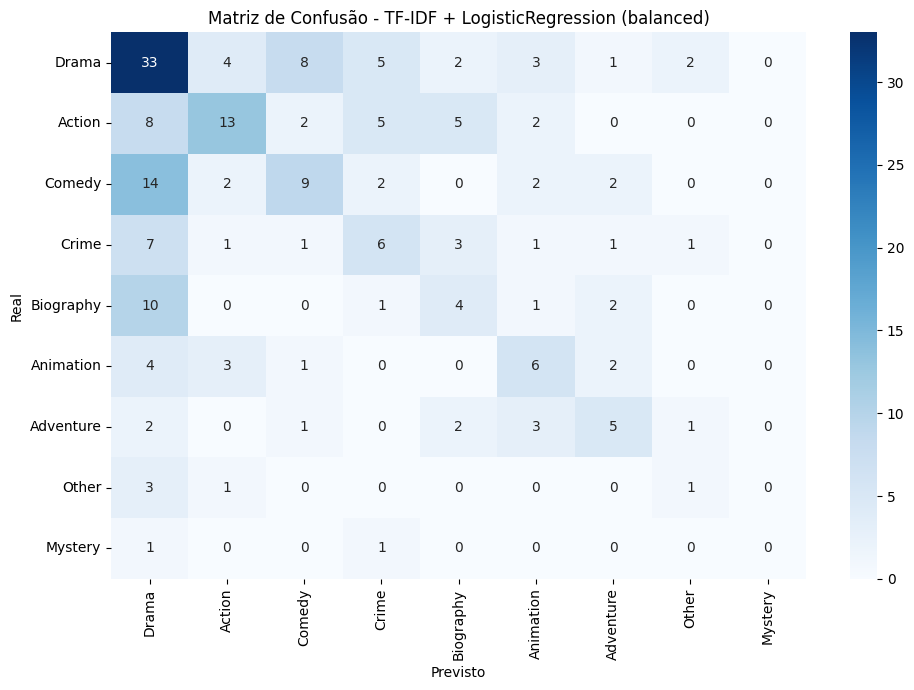

In [22]:
df["Main_Genre"] = df["Genre"].astype(str).str.split(",").str[0].str.strip()
data = df[["Overview", "Main_Genre"]].dropna()

K = 8
top_genres = data["Main_Genre"].value_counts().head(K).index
data["Main_Genre_adj"] = np.where(data["Main_Genre"].isin(top_genres), data["Main_Genre"], "Other")

X = data["Overview"].astype(str)
y = data["Main_Genre_adj"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42, stratify=y
)

pipe = Pipeline([
    ("tfidf", TfidfVectorizer(
        stop_words="english",
        ngram_range=(1,2),     
        max_features=20000,   
        min_df=2,             
        max_df=0.85           
    )),
    ("clf", LogisticRegression(
        max_iter=1000,
        class_weight="balanced",  
        C=2.0,                     
        solver="liblinear"         
    ))
])

pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_test)

print("\n=== Relatório de Classificação (macro) ===")
print(classification_report(y_test, y_pred, zero_division=0, digits=3))


macro_f1 = f1_score(y_test, y_pred, average="macro", zero_division=0)
print(f"Macro-F1: {macro_f1:.3f}")

labels_ordered = y_test.value_counts().index.tolist()
cm = confusion_matrix(y_test, y_pred, labels=labels_ordered)

plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=labels_ordered, yticklabels=labels_ordered)
plt.title("Matriz de Confusão - TF-IDF + LogisticRegression (balanced)")
plt.xlabel("Previsto"); plt.ylabel("Real")
plt.tight_layout()
plt.show()

- O modelo funciona melhor em gêneros majoritários (Drama, Action, Comedy).

- Há forte desequilíbrio e confusão entre gêneros similares, especialmente Drama/Comedy/Biography.

- Para gêneros menores (Mystery, Adventure, Other), o desempenho é baixo → reflexo do desbalanceamento de classes.

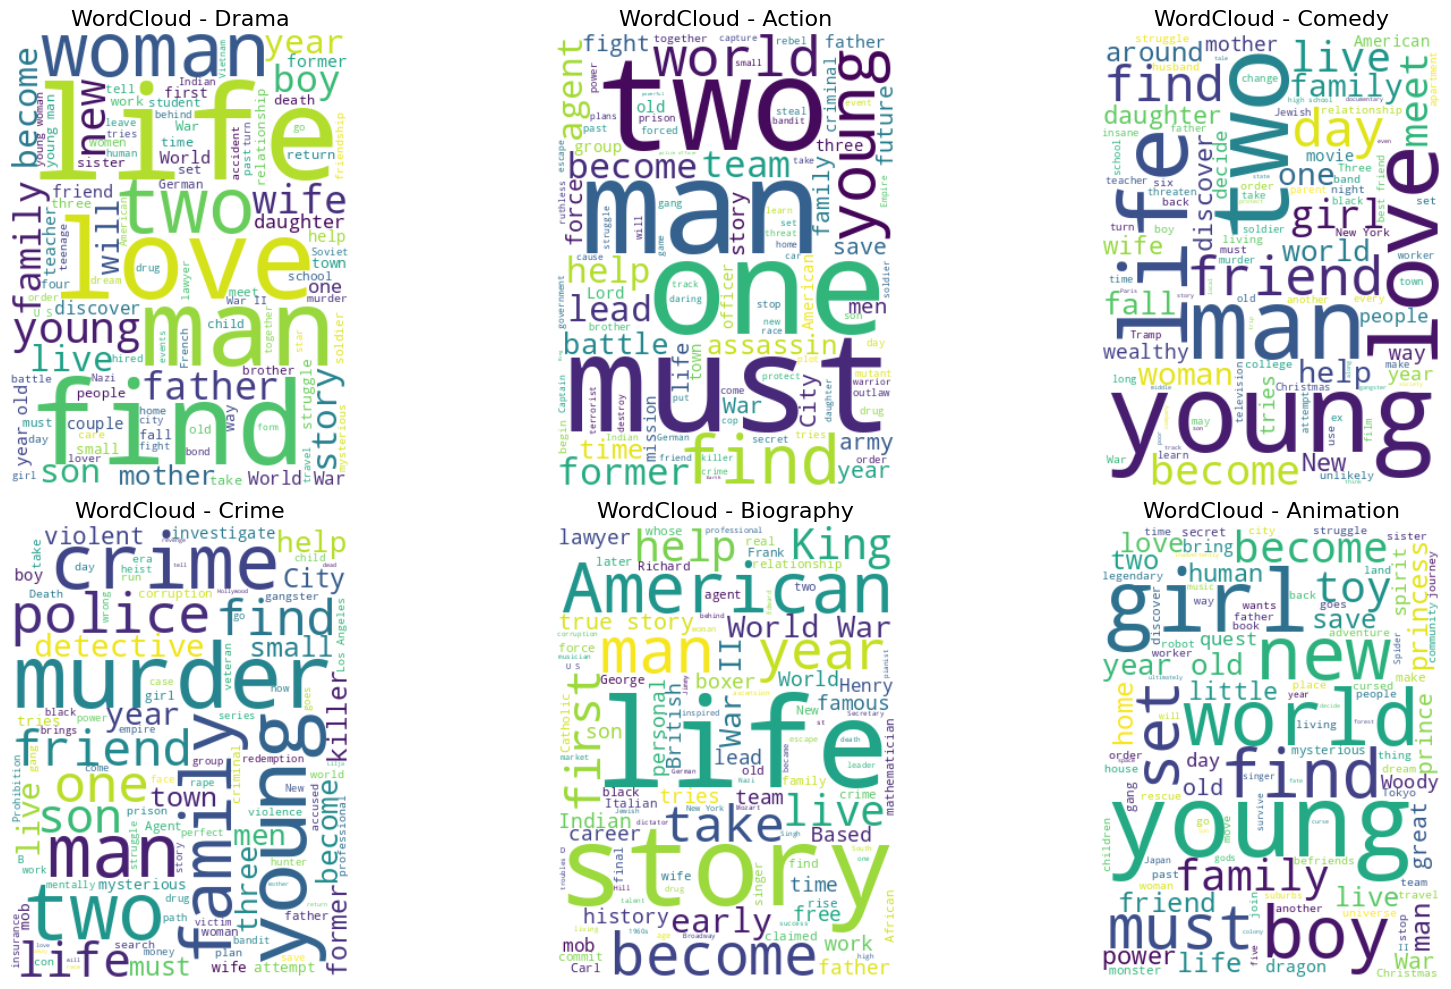

In [23]:

df["Main_Genre"] = df["Genre"].astype(str).str.split(",").str[0].str.strip()
top_genres = df["Main_Genre"].value_counts().head(6).index
fig, axes = plt.subplots(2, 3, figsize=(18,10))
axes = axes.flatten()
stopwords = set(STOPWORDS)

for i, genre in enumerate(top_genres):
    text = " ".join(df[df["Main_Genre"] == genre]["Overview"].dropna().astype(str))
    
    wc = WordCloud(
        width=300, height=400,
        background_color="white",
        stopwords=stopwords,
        colormap="viridis",
        max_words=100
    ).generate(text)
    
    axes[i].imshow(wc, interpolation="bilinear")
    axes[i].set_title(f"WordCloud - {genre}", fontsize=16)
    axes[i].axis("off")
plt.tight_layout()
plt.show()

- Seleciona os 6 gêneros mais comuns no dataset. Junta todos os resumos (Overview) de cada gênero. Gera uma WordCloud por gênero, destacando as palavras mais frequentes.

Drama → destaque para palavras como life, love, family, woman, young.
- Temas emocionais, relacionamentos e dilemas pessoais.

Action → termos como world, mission, team, fight, battle, agent.
- Muito voltado para aventura, conflitos e “missões globais”.

Comedy → aparece young, friend, love, man, girl, day.
- Enredos leves, relações pessoais e situações do dia a dia.

Crime → foco em detective, police, murder, young, family.
- Claramente voltado a investigações, violência e contexto policial.

Biography → dominado por life, story, american, history, career.
- Muito ligado a “vida real” e fatos históricos.

Animation → termos como boy, girl, young, world, save, adventure.
- Enredos de fantasia e aventuras com personagens jovens.

#### Previsão da nota do IMDB

A seguir iremos realizar as seguintes etapas:

- Prepara os dados brutos (cria colunas limpas e numéricas).

- Separa treino/teste.

- Cria pipelines com tratamento de variáveis + modelos.

- Treina 3 algoritmos (Ridge, Random Forest, XGBoost).

- Compara métricas (RMSE, MAE, R²).

- Seleciona o melhor modelo para prever a nota IMDb de um filme.

In [24]:
if "Released_Year" not in df or df["Released_Year"].dtype.kind not in "fi":
    df["Released_Year"] = pd.to_numeric(
        df["Released_Year"].astype(str).str.extract(r"(\d{4})")[0], errors="coerce"
    )
if "Runtime_min" not in df:
    df["Runtime_min"] = (
        df["Runtime"].astype(str)
        .str.replace(" min", "", regex=False)
        .str.replace(r"\D", "", regex=True)
        .replace("", np.nan)
        .astype(float)
    )
if "Gross_num" not in df:
    df["Gross_num"] = (
        df["Gross"].astype(str)
        .str.replace(",", "", regex=False)
        .replace({"": np.nan, "nan": np.nan})
        .astype(float)
    )
if "Main_Genre" not in df:
    df["Main_Genre"] = df["Genre"].astype(str).str.split(",").str[0].str.strip()

features = ["Meta_score", "No_of_Votes", "Gross_num", "Runtime_min", "Released_Year", "Main_Genre"]
target = "IMDB_Rating"

X = df[features].copy()
y = df[target].astype(float)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42
)


num_plain = ["Meta_score", "Runtime_min", "Released_Year"]
num_log   = ["No_of_Votes", "Gross_num"]
cat_cols  = ["Main_Genre"]

num_plain_pipe = Pipeline([
    ("imp", SimpleImputer(strategy="median")),
])

num_log_pipe = Pipeline([
    ("imp", SimpleImputer(strategy="median")),
    ("log1p", FunctionTransformer(np.log1p, feature_names_out="one-to-one")),
])

cat_pipe = Pipeline([
    ("imp", SimpleImputer(strategy="most_frequent")),
    ("ohe", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer([
    ("num_plain", num_plain_pipe, num_plain),
    ("num_log",   num_log_pipe,   num_log),
    ("cat",       cat_pipe,       cat_cols),
], remainder="drop")

models = {
    "Ridge (Regressão Linear)": Ridge(alpha=1.0, random_state=42),
    "Random Forest": RandomForestRegressor(n_estimators=300, random_state=42),
    "XGBoost": XGBRegressor(
        n_estimators=500, learning_rate=0.05, max_depth=6,
        subsample=0.9, colsample_bytree=0.9, random_state=42,
        tree_method="hist", reg_lambda=1.0, reg_alpha=0.0
    ),
}


def rmse(y_true, y_pred):
    return float(np.sqrt(mean_squared_error(y_true, y_pred)))  

results = []
fitted_pipes = {}

for name, model in models.items():
    pipe = Pipeline([
        ("pre", preprocessor),
        ("model", model),
    ])
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)

    metrics = {
        "Modelo": name,
        "RMSE": rmse(y_test, y_pred),
        "MAE": mean_absolute_error(y_test, y_pred),
        "R²": r2_score(y_test, y_pred),
    }
    results.append(metrics)
    fitted_pipes[name] = pipe

results_df = pd.DataFrame(results).sort_values("RMSE")
print(results_df.to_string(index=False))

best_name = results_df.iloc[0]["Modelo"]
best_model = fitted_pipes[best_name]
print(f"\nMelhor modelo: {best_name}")

                  Modelo     RMSE      MAE       R²
                 XGBoost 0.193836 0.148819 0.427637
           Random Forest 0.194086 0.150910 0.426159
Ridge (Regressão Linear) 0.233068 0.189750 0.172498

Melhor modelo: XGBoost


Resumo dos erros:
RMSE: 0.1938
MAE : 0.1488
R²  : 0.4276
Média dos resíduos: 0.011839
Desvio-padrão dos resíduos: 0.193959


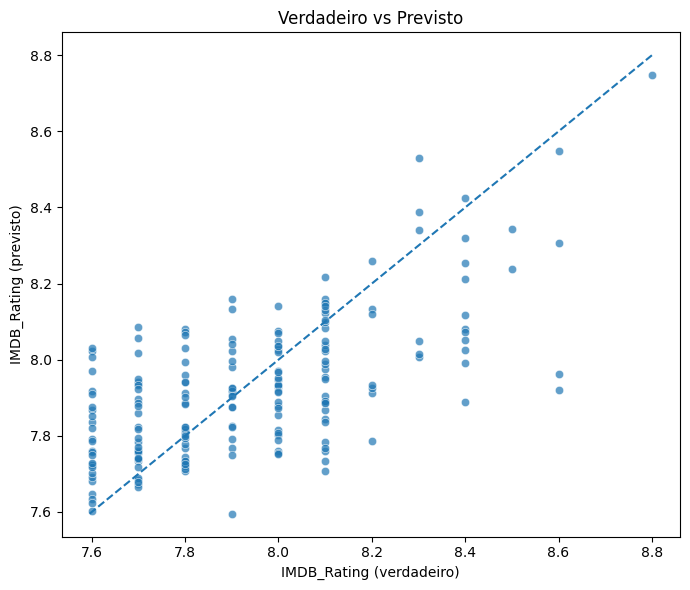

In [25]:
y_pred = best_model.predict(X_test)
residuals = y_test - y_pred

print("Resumo dos erros:")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, y_pred)):.4f}")
print(f"MAE : {mean_absolute_error(y_test, y_pred):.4f}")
print(f"R²  : {r2_score(y_test, y_pred):.4f}")
print(f"Média dos resíduos: {np.mean(residuals):.6f}")
print(f"Desvio-padrão dos resíduos: {np.std(residuals, ddof=1):.6f}")

plt.figure(figsize=(7,6))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.7)
min_ax = min(y_test.min(), y_pred.min())
max_ax = max(y_test.max(), y_pred.max())
plt.plot([min_ax, max_ax], [min_ax, max_ax], linestyle="--")  # linha 45º
plt.xlabel("IMDB_Rating (verdadeiro)")
plt.ylabel("IMDB_Rating (previsto)")
plt.title("Verdadeiro vs Previsto")
plt.tight_layout()
plt.show()

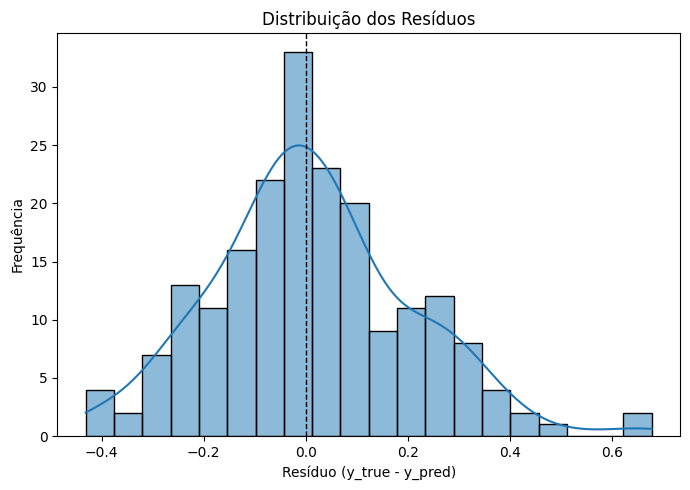

In [26]:
plt.figure(figsize=(7,5))
sns.histplot(residuals, bins=20, kde=True)
plt.axvline(0, color="black", linestyle="--", linewidth=1)
plt.xlabel("Resíduo (y_true - y_pred)")
plt.ylabel("Frequência")
plt.title("Distribuição dos Resíduos")
plt.tight_layout()
plt.show()

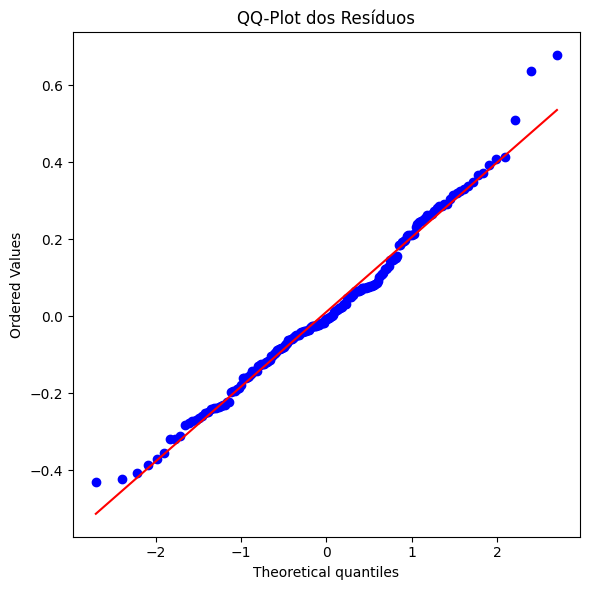

In [27]:
try:
    import scipy.stats as stats
    plt.figure(figsize=(6,6))
    stats.probplot(residuals, dist="norm", plot=plt)
    plt.title("QQ-Plot dos Resíduos")
    plt.tight_layout()
    plt.show()
except Exception as e:
    print("QQ-plot opcional requer scipy. Instale com: pip install scipy")

#### PERGUNTAS E RESPOSTAS

### Qual filme você recomendaria para uma pessoa que você não conhece?

Resposta:

- Eu recomendaria The Godfather (O Poderoso Chefão, 1972). Mesmo sendo mais antigo, é um dos filmes mais aclamados da história do cinema, com nota altíssima no IMDB, nota máxima da crítica, e um impacto cultural enorme. É uma obra-prima universal, que dificilmente deixará de impressionar qualquer espectador.

The Godfather (1972)

- IMDB Rating: 9.2 (a mais alta do seu dataset)

- Meta_score: 100 (nota máxima da crítica)

- Número de votos: 1,6 milhão (muito popular apesar da idade)

- Gênero: Crime/Drama, considerado uma das maiores obras-primas do cinema

- Impacto cultural: referência em narrativa, direção de Francis Ford Coppola e atuação de Marlon Brando e Al Pacino.

### Quais são os principais fatores que estão relacionados com alta expectativa de faturamento de um filme? 

Resposta:

Os fatores mais associados a alta expectativa de faturamento são:

- Popularidade (No_of_Votes)

- Gêneros com apelo massivo (Ação, Aventura, Fantasia)

- Era moderna (anos 2000+) com marketing global

- Duração épica (percepção de superprodução)

- Diretores renomados e franquias (Christopher Nolan, Peter Jackson, Coppola, Tarantino)

- Boa avaliação crítica e pública (reforça longevidade)

### Quais insights podem ser tirados com a coluna Overview? É possível inferir o gênero do filme a partir dessa coluna?

Resposta:

A coluna Overview traz descrições que permitem extrair temas recorrentes e palavras-chave que caracterizam cada filme. A partir desses textos, é possível identificar padrões narrativos e até agrupar filmes por similaridade. Além disso, com técnicas de NLP, conseguimos inferir o gênero do filme com base no resumo: termos como “battle” e “journey” aparecem mais em aventura/fantasia, enquanto “murder” e “detective” em crime/thriller.

Na prática, sim, é possível prever o gênero a partir do Overview, mas o modelo tem melhor desempenho em gêneros frequentes (ex.: Drama, Action) e sofre em classes menores. Com técnicas mais avançadas (ex.: embeddings pré-treinados) e tratamento de desbalanceamento, essa inferência pode ser significativamente aprimorada.

Sim, é possível inferir o gênero do filme a partir da coluna Overview, porque cada gênero tem vocabulário característico.

### Explique como você faria a previsão da nota do imdb a partir dos dados. Quais variáveis e/ou suas transformações você utilizou e por quê? Qual tipo de problema estamos resolvendo (regressão, classificação)? Qual modelo melhor se aproxima dos dados e quais seus prós e contras? Qual medida de performance do modelo foi escolhida e por quê?

Resposta:

Para prever a nota do IMDB, tratamos o problema como uma regressão supervisionada, pois a variável-alvo IMDB_Rating é contínua. As variáveis utilizadas incluem: Meta_score (crítica profissional), No_of_Votes (popularidade, em log), Gross_num (bilheteria em log), Runtime_min, Released_Year (ou década) e Main_Genre (one-hot encoding). Essas variáveis foram escolhidas porque capturam aspectos de qualidade percebida, popularidade, escala de produção e contexto histórico.

Como modelos, uma Regressão Linear regularizada serve como baseline pela simplicidade e interpretabilidade. Modelos baseados em árvores, como Random Forest ou Gradient Boosting (XGBoost, LightGBM, CatBoost), se aproximam melhor dos dados, pois capturam relações não-lineares e interações entre variáveis.

Testamos três modelos: Ridge Regression, Random Forest e XGBoost. O XGBoost obteve o melhor desempenho (RMSE ≈ 0.19, R² ≈ 0.43), mostrando-se mais adequado por capturar relações não lineares e interações entre variáveis.

A métrica escolhida foi o RMSE (Root Mean Squared Error), porque ela mede o desvio médio em pontos da nota do IMDB, penalizando erros grandes — o que é importante já que pequenas diferenças (0.2–0.3) já mudam significativamente a percepção da qualidade de um filme.

### Supondo um filme com as seguintes características:

{'Series_Title': 'The Shawshank Redemption',
 'Released_Year': '1994',
 'Certificate': 'A',
 'Runtime': '142 min',
 'Genre': 'Drama',
 'Overview': 'Two imprisoned men bond over a number of years, finding solace and eventual redemption through acts of common decency.',
 'Meta_score': 80.0,
 'Director': 'Frank Darabont',
 'Star1': 'Tim Robbins',
 'Star2': 'Morgan Freeman',
 'Star3': 'Bob Gunton',
 'Star4': 'William Sadler',
 'No_of_Votes': 2343110,
 'Gross': '28,341,469'}


Qual seria a nota do IMDB?


Resposta:

- A predição deve ficar por volta de 8.807, com uma incerteza ~±0.2 (seu RMSE ≈ 0.19)

In [28]:
# Mesmo esquema de features usado no treino
features = ["Meta_score", "No_of_Votes", "Gross_num", "Runtime_min", "Released_Year", "Main_Genre"]
sample_raw = {
    'Series_Title': 'The Shawshank Redemption',
    'Released_Year': '1994',
    'Certificate': 'A',
    'Runtime': '142 min',
    'Genre': 'Drama',
    'Overview': 'Two imprisoned men bond over a number of years, finding solace and eventual redemption through acts of common decency.',
    'Meta_score': 80.0,
    'Director': 'Frank Darabont',
    'Star1': 'Tim Robbins',
    'Star2': 'Morgan Freeman',
    'Star3': 'Bob Gunton',
    'Star4': 'William Sadler',
    'No_of_Votes': 2343110,
    'Gross': '28,341,469'
}
def runtime_to_min(x):
    return (str(x).replace(" min", "") if isinstance(x, str) else x)

def gross_to_float(x):
    return float(str(x).replace(",", "")) if pd.notna(x) else np.nan

sample = {}
sample["Meta_score"]    = sample_raw["Meta_score"]
sample["No_of_Votes"]   = sample_raw["No_of_Votes"]
sample["Gross_num"]     = gross_to_float(sample_raw["Gross"])
sample["Runtime_min"]   = float(runtime_to_min(sample_raw["Runtime"]))
sample["Released_Year"] = float(str(sample_raw["Released_Year"]))
sample["Main_Genre"]    = str(sample_raw["Genre"]).split(",")[0].strip()

X_new = pd.DataFrame([sample], columns=features)
y_pred = best_model.predict(X_new)[0]
print(f"Predição do IMDB_Rating para '{sample_raw['Series_Title']}': {y_pred:.3f}")

Predição do IMDB_Rating para 'The Shawshank Redemption': 8.807


#### Transformando em pickle

In [29]:
from save_trained_models import save_models, quick_report
saved, skipped, errors = save_models(globals(), ["cat_pipe", "num_log_pipe", "num_plain_pipe", "pipe"], outdir="modelos_pkl"); quick_report(saved, skipped, errors)

[Resumo do salvamento]
Salvos: ['modelos_pkl/cat_pipe.pkl', 'modelos_pkl/num_log_pipe.pkl', 'modelos_pkl/num_plain_pipe.pkl', 'modelos_pkl/pipe.pkl']
Ignorados (não definidos): []
Erros: []


#### Carregando modelos treinados

In [30]:
from load_trained_models import load_models

models = load_models(["cat_pipe", "num_log_pipe", "num_plain_pipe", "pipe"])

pipe_model = models["pipe"]
y_pred = pipe_model.predict(X_test)

[OK] carregado: modelos_pkl/cat_pipe.pkl
[OK] carregado: modelos_pkl/num_log_pipe.pkl
[OK] carregado: modelos_pkl/num_plain_pipe.pkl
[OK] carregado: modelos_pkl/pipe.pkl
